# Project for CS545

Sam Armstrong, Saloni Choudhary, Brandon Hua

In [237]:
import pandas as pd
import datetime
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import ConvLSTM2D
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from tensorflow.keras.regularizers import l1, l2, l1_l2
import math
from sklearn.metrics import mean_squared_error

## Get Data


In [238]:
# Run these pip3 installs once to install yahoo finance libraries
# !pip3 install yahoo-finance --user
# !pip3 install yfinance --user --upgrade --no-cache-dir

import yfinance as yf
# Documentation at https://pypi.org/project/yfinance/

In [239]:
tickers = 'mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt'
# exclude dwdp because it's historical data only goes back 1 year
period = '5y'

data = yf.download(tickers, period=period)
data.columns = ['%s%s' % (a, ' %s' % b if b else '') for a, b in data.columns]
data[data.isna().any(axis=1)] #Display rows with Null values

[*********************100%***********************]  29 of 29 completed


,Adj Close AAPL,Adj Close AXP,Adj Close BA,Adj Close CAT,Adj Close CSCO,Adj Close CVX,Adj Close DIS,Adj Close GE,Adj Close GS,Adj Close HD,...,Volume NKE,Volume PFE,Volume PG,Volume TRV,Volume UNH,Volume UTX,Volume V,Volume VZ,Volume WMT,Volume XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [240]:
data = data.drop([datetime.datetime(2016, 1, 18)])
data.shape

(1258, 174)

## Data

The data comprises of 29 stocks [mmm axp aapl ba cat cvx csco ko dis xom ge gs hd ibm intc jnj jpm mcd mrk msft nke pfe pg trv utx unh vz v wmt] over a 5 year period (end date is current date) with 252 days in a year (except 2016 whichis missing the date 2016-01-18). Each date entry has 6 variables [Adjusted Close, Close, High, Low, Open, Volume]. We are trying to predict the next day's Close. 

In [241]:
MMM = data[['Adj Close MMM', 'Close MMM', 'High MMM', 'Low MMM', 'Open MMM', 'Volume MMM']]
MMM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
AAPL = data[['Adj Close AAPL', 'Close AAPL', 'High AAPL', 'Low AAPL', 'Open AAPL', 'Volume AAPL']]
AAPL.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
AXP = data[['Adj Close AXP', 'Close AXP', 'High AXP', 'Low AXP', 'Open AXP', 'Volume AXP']]
AXP.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
BA = data[['Adj Close BA', 'Close BA', 'High BA', 'Low BA', 'Open BA', 'Volume BA']]
BA.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CAT = data[['Adj Close CAT', 'Close CAT', 'High CAT', 'Low CAT', 'Open CAT', 'Volume CAT']]
CAT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CVX = data[['Adj Close CVX', 'Close CVX', 'High CVX', 'Low CVX', 'Open CVX', 'Volume CVX']]
CVX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
CSCO = data[['Adj Close CSCO', 'Close CSCO', 'High CSCO', 'Low CSCO', 'Open CSCO', 'Volume CSCO']]
CSCO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
KO = data[['Adj Close KO', 'Close KO', 'High KO', 'Low KO', 'Open KO', 'Volume KO']]
KO.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
DIS = data[['Adj Close DIS', 'Close DIS', 'High DIS', 'Low DIS', 'Open DIS', 'Volume DIS']]
DIS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
XOM = data[['Adj Close XOM', 'Close XOM', 'High XOM', 'Low XOM', 'Open XOM', 'Volume XOM']]
XOM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GE = data[['Adj Close GE', 'Close GE', 'High GE', 'Low GE', 'Open GE', 'Volume GE']]
GE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
GS = data[['Adj Close GS', 'Close GS', 'High GS', 'Low GS', 'Open GS', 'Volume GS']]
GS.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
HD = data[['Adj Close HD', 'Close HD', 'High HD', 'Low HD', 'Open HD', 'Volume HD']]
HD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
IBM = data[['Adj Close IBM', 'Close IBM', 'High AAPL', 'Low IBM', 'Open IBM', 'Volume IBM']]
IBM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
INTC = data[['Adj Close INTC', 'Close INTC', 'High INTC', 'Low INTC', 'Open INTC', 'Volume INTC']]
INTC.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JNJ = data[['Adj Close JNJ', 'Close JNJ', 'High JNJ', 'Low JNJ', 'Open JNJ', 'Volume JNJ']]
JNJ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
JPM = data[['Adj Close JPM', 'Close JPM', 'High JPM', 'Low JPM', 'Open JPM', 'Volume JPM']]
JPM.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MCD = data[['Adj Close MCD', 'Close MCD', 'High MCD', 'Low MCD', 'Open MCD', 'Volume MCD']]
MCD.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MRK = data[['Adj Close MRK', 'Close MRK', 'High MRK', 'Low MRK', 'Open MRK', 'Volume MRK']]
MRK.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
MSFT = data[['Adj Close MSFT', 'Close MSFT', 'High MSFT', 'Low MSFT', 'Open MSFT', 'Volume MSFT']]
MSFT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
NKE = data[['Adj Close NKE', 'Close NKE', 'High NKE', 'Low NKE', 'Open NKE', 'Volume NKE']]
NKE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PFE = data[['Adj Close PFE', 'Close PFE', 'High PFE', 'Low PFE', 'Open PFE', 'Volume PFE']]
PFE.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
PG = data[['Adj Close PG', 'Close PG', 'High PG', 'Low PG', 'Open PG', 'Volume PG']]
PG.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
TRV = data[['Adj Close TRV', 'Close TRV', 'High TRV', 'Low TRV', 'Open TRV', 'Volume TRV']]
TRV.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UTX = data[['Adj Close UTX', 'Close UTX', 'High UTX', 'Low UTX', 'Open UTX', 'Volume UTX']]
UTX.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
UNH = data[['Adj Close UNH', 'Close UNH', 'High UNH', 'Low UNH', 'Open UNH', 'Volume UNH']]
UNH.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
VZ = data[['Adj Close VZ', 'Close VZ', 'High VZ', 'Low VZ', 'Open VZ', 'Volume VZ']]
VZ.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
V = data[['Adj Close V', 'Close V', 'High V', 'Low V', 'Open V', 'Volume V']]
V.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
WMT = data[['Adj Close WMT', 'Close WMT', 'High WMT', 'Low WMT', 'Open WMT', 'Volume WMT']]
WMT.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

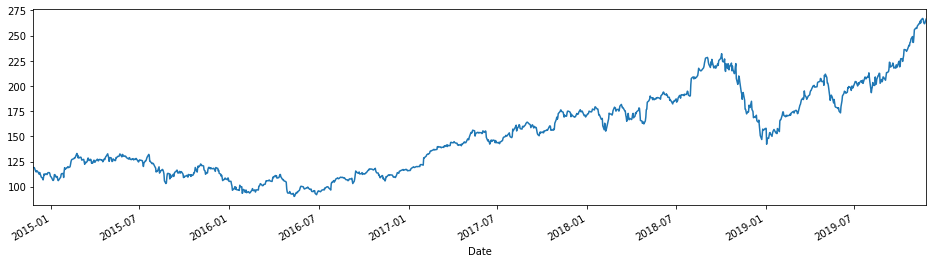

In [242]:
AAPL['Close'].plot(figsize=(16,4))

In [243]:
def univariate_data_setup(dataset,look_back, train_percent):
    n_train = int(train_percent * len(dataset))
    training_set = dataset[:n_train]
    training_set=pd.DataFrame(training_set)
    testing_set = dataset[n_train - look_back:]
    testing_set=pd.DataFrame(testing_set)
    return training_set, testing_set

def univariate_partition_data(training_set_scaled, testing_set_scaled, look_back):
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    for i in range(look_back, training_set_scaled.shape[0]):
        X_train.append(training_set_scaled[i-look_back:i, 0])
        Y_train.append(training_set_scaled[i, 0])
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    for i in range(look_back, testing_set_scaled.shape[0]):
        X_test.append(testing_set_scaled[i-look_back:i, 0])
        Y_test.append(testing_set_scaled[i, 0])
    X_test, Y_test = np.array(X_test), np.array(Y_test)
    
    return X_train, Y_train, X_test, Y_test
    
    

def plot(predicted, y):
    plt.figure(figsize=(15, 10))
    plt.subplot(2, 1, 1)
    plt.plot(predicted)
    plt.plot(y)
    
    plt.subplot(2, 1, 2)
    rse = np.sqrt((predicted - y)**2)
    plt.plot(rse)
    plt.show()
    
    rmse = np.mean(rse)
    print('RMSE: %.2f' % rmse)

## Univariate Model

In [244]:
#Partitioning dataset for training and testing 
univariate_seq = AAPL['Close']
training_set, testing_set =  univariate_data_setup(univariate_seq, 60, 0.8)


#Scaling the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))


X_train, Y_train, X_test, Y_test = univariate_partition_data(training_set_scaled, testing_set_scaled, 60)

#Reshaping X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [245]:
#Creating the model
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.25))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.3))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.25))

# Adding the output layer
regressor.add(Dense(units = 1))


# Compiling the Model
regressor.compile(optimizer = 'adam' , loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history=regressor.fit(X_train, Y_train, epochs = 10, batch_size = 32)

Train on 946 samples
Epoch 1/10
946/946 [==============================] - 7s 8ms/sample - loss: 0.0435
Epoch 2/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0066
Epoch 3/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0051
Epoch 4/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0050
Epoch 5/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0045
Epoch 6/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0042
Epoch 7/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0048
Epoch 8/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0050
Epoch 9/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0044
Epoch 10/10
946/946 [==============================] - 3s 3ms/sample - loss: 0.0043


In [246]:
# evaluate the model
train_mse = regressor.evaluate(X_train, Y_train, verbose=0)
test_mse = regressor.evaluate(X_test, Y_test , verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.003, Test: 0.007


Train Score: 0.0527 RMSE


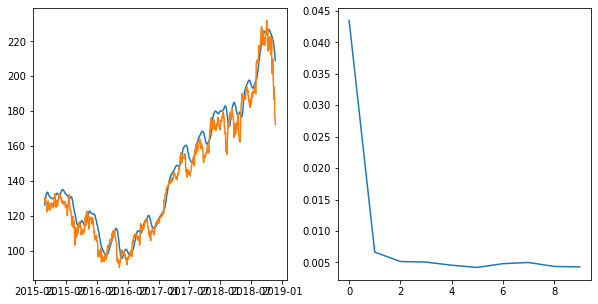

In [247]:
train_set_prediction = regressor.predict(X_train).reshape(-1, 1)
trainScore_rnn = math.sqrt(mean_squared_error(Y_train,train_set_prediction))
print('Train Score: %.4f RMSE' % (trainScore_rnn))

train_set_prediction = sc.inverse_transform(train_set_prediction)


train_set_prediction = pd.DataFrame(train_set_prediction)


train_set_prediction.index = training_set[look_back:].index



plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_set_prediction)
plt.plot(training_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])


Test Score: 0.08 RMSE


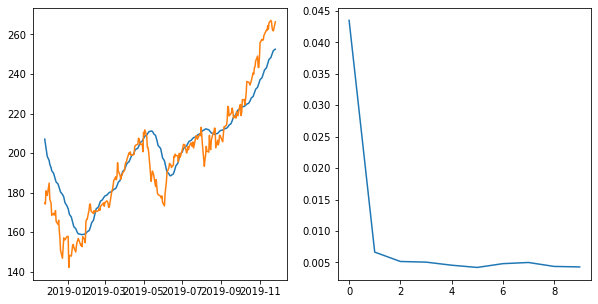

In [248]:
test_set_predicted = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predicted))
print('Test Score: %.2f RMSE' % (testScore_rnn))

test_set_predicted = sc.inverse_transform(test_set_predicted)
test_set_predicted = pd.DataFrame(test_set_predicted)# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_set_predicted.index = testing_set[look_back:].index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_set_predicted)
plt.plot(testing_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])




### Univariate Regularization

1. Applying regularizations to the input layer using kernel_regularizer


## L1 with different optimizers(SGD, Adam, Adagrad)

In [249]:
#Partitioning dataset for training and testing 
univariate_seq = AAPL['Close']
training_set, testing_set =  univariate_data_setup(univariate_seq, 60, 0.8)


#Scaling the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))


X_train, Y_train, X_test, Y_test = univariate_partition_data(training_set_scaled, testing_set_scaled, 60)

#Reshaping X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [250]:
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.0001), bias_regularizer=l1(0.0001)))
regressor.add(Dropout(0.25))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 15, batch_size = 50)

Train on 946 samples
Epoch 1/15
946/946 [==============================] - 2s 2ms/sample - loss: 0.1263
Epoch 2/15
946/946 [==============================] - 1s 543us/sample - loss: 0.0617
Epoch 3/15
946/946 [==============================] - 1s 574us/sample - loss: 0.0511
Epoch 4/15
946/946 [==============================] - 1s 560us/sample - loss: 0.0429
Epoch 5/15
946/946 [==============================] - 1s 562us/sample - loss: 0.0377
Epoch 6/15
946/946 [==============================] - 1s 536us/sample - loss: 0.0328
Epoch 7/15
946/946 [==============================] - 1s 567us/sample - loss: 0.0295
Epoch 8/15
946/946 [==============================] - 1s 547us/sample - loss: 0.0276
Epoch 9/15
946/946 [==============================] - 1s 551us/sample - loss: 0.0253
Epoch 10/15
946/946 [==============================] - 1s 573us/sample - loss: 0.0234
Epoch 11/15
946/946 [==============================] - 1s 555us/sample - loss: 0.0223
Epoch 12/15
946/946 [=======================

In [251]:
# evaluate the model
train_mse = regressor.evaluate(X_train, Y_train, verbose=0)
test_mse = regressor.evaluate(X_test, Y_test , verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.017, Test: 0.020


Train Score: 0.0373 RMSE


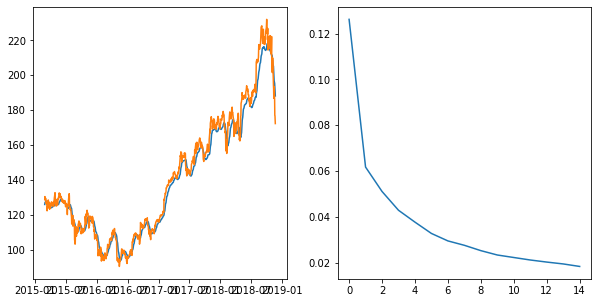

In [252]:
train_set_prediction = regressor.predict(X_train).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train,train_set_prediction))
print('Train Score: %.4f RMSE' % (trainScore_rnn))

train_set_prediction = sc.inverse_transform(train_set_prediction)
train_set_prediction = pd.DataFrame (train_set_prediction)

train_set_prediction.index = training_set[look_back:].index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_set_prediction)
plt.plot(training_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])



Test Score: 0.07 RMSE


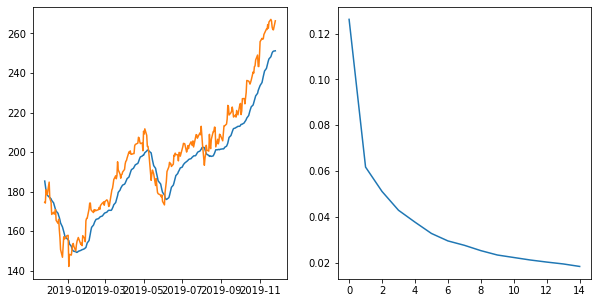

In [253]:
test_set_predicted = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predicted))
print('Test Score: %.2f RMSE' % (testScore_rnn))

test_set_predicted = sc.inverse_transform(test_set_predicted)
test_set_predicted = pd.DataFrame(test_set_predicted)# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_set_predicted.index = testing_set[look_back:].index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_set_predicted)
plt.plot(testing_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

In [254]:
#Partitioning dataset for training and testing 
univariate_seq = AAPL['Close']
training_set, testing_set =  univariate_data_setup(univariate_seq, 60, 0.8)


#Scaling the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))


X_train, Y_train, X_test, Y_test = univariate_partition_data(training_set_scaled, testing_set_scaled, 60)

#Reshaping X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#Creating a model
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l1(0.0001), recurrent_regularizer=l1(0.001), bias_regularizer=l1(0.001), return_sequences= True))


regressor.add(LSTM(units = 25,kernel_regularizer=l1(0.001), recurrent_regularizer=l1(0.001), bias_regularizer=l1(0.001), return_sequences= True))
regressor.add(Dropout (.2))

regressor.add(LSTM(units = 25))
regressor.add(Dropout(0.25))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam' , loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 15, batch_size = 50)


Train on 946 samples
Epoch 1/15
946/946 [==============================] - 5s 5ms/sample - loss: 0.7269
Epoch 2/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.5838
Epoch 3/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.4858
Epoch 4/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.4044
Epoch 5/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.3337
Epoch 6/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.2742
Epoch 7/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.2255
Epoch 8/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.1864
Epoch 9/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.1552
Epoch 10/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.1317
Epoch 11/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.1130
Epoch 12/15
946/946 [==============================] - 1s 2ms/sa

In [255]:
# evaluate the model
train_mse = regressor.evaluate(X_train, Y_train, verbose=0)
test_mse = regressor.evaluate(X_test, Y_test , verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.074, Test: 0.079


Train Score: 0.0530 RMSE


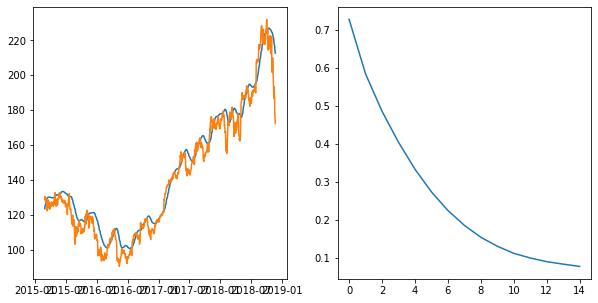

In [256]:
train_set_prediction = regressor.predict(X_train).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train,train_set_prediction))
print('Train Score: %.4f RMSE' % (trainScore_rnn))

train_set_prediction = sc.inverse_transform(train_set_prediction)
train_set_prediction = pd.DataFrame (train_set_prediction)

train_set_prediction.index = training_set[look_back:].index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_set_prediction)
plt.plot(training_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.09 RMSE


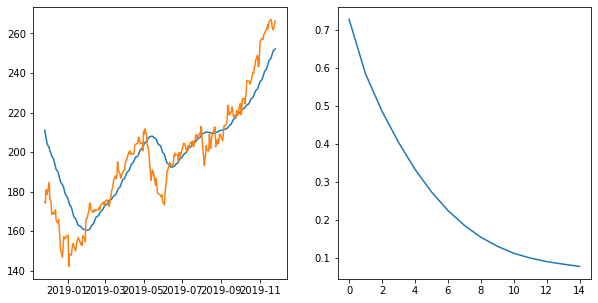

In [257]:
test_set_predicted = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predicted))
print('Test Score: %.2f RMSE' % (testScore_rnn))

test_set_predicted = sc.inverse_transform(test_set_predicted)
test_set_predicted = pd.DataFrame(test_set_predicted)# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_set_predicted.index = testing_set[look_back:].index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_set_predicted)
plt.plot(testing_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

## L2 with different optimizers(SGD, Adam, Adagrad)

In [258]:
#Partitioning dataset for training and testing 
univariate_seq = AAPL['Close']
training_set, testing_set =  univariate_data_setup(univariate_seq, 60, 0.8)


#Scaling the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))


X_train, Y_train, X_test, Y_test = univariate_partition_data(training_set_scaled, testing_set_scaled, 60)

#Reshaping X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#Creating a model

regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001), bias_regularizer=l2(0.001)))

regressor.add(Dropout(0.3))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam' , loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 15, batch_size = 50)


Train on 946 samples
Epoch 1/15
946/946 [==============================] - 2s 2ms/sample - loss: 0.1599
Epoch 2/15
946/946 [==============================] - 1s 571us/sample - loss: 0.0715
Epoch 3/15
946/946 [==============================] - 1s 534us/sample - loss: 0.0590
Epoch 4/15
946/946 [==============================] - 1s 546us/sample - loss: 0.0528
Epoch 5/15
946/946 [==============================] - 1s 563us/sample - loss: 0.0470
Epoch 6/15
946/946 [==============================] - 1s 545us/sample - loss: 0.0480
Epoch 7/15
946/946 [==============================] - 1s 547us/sample - loss: 0.0418
Epoch 8/15
946/946 [==============================] - 0s 528us/sample - loss: 0.0398
Epoch 9/15
946/946 [==============================] - 0s 512us/sample - loss: 0.0381
Epoch 10/15
946/946 [==============================] - 0s 520us/sample - loss: 0.0367
Epoch 11/15
946/946 [==============================] - 1s 546us/sample - loss: 0.0362
Epoch 12/15
946/946 [=======================

In [259]:
# evaluate the model
train_mse = regressor.evaluate(X_train, Y_train, verbose=0)
test_mse = regressor.evaluate(X_test, Y_test , verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.026, Test: 0.031


Train Score: 0.0381 RMSE


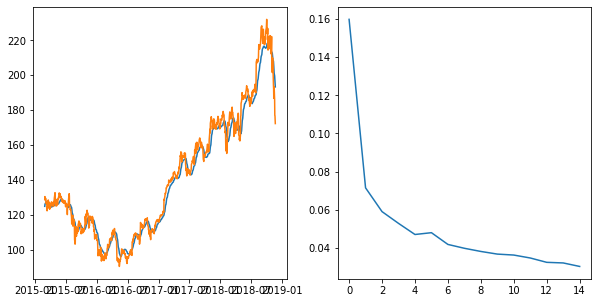

In [260]:
train_set_prediction = regressor.predict(X_train).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train,train_set_prediction))
print('Train Score: %.4f RMSE' % (trainScore_rnn))

train_set_prediction = sc.inverse_transform(train_set_prediction)
train_set_prediction = pd.DataFrame (train_set_prediction)

train_set_prediction.index = training_set[look_back:].index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_set_prediction)
plt.plot(training_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.08 RMSE


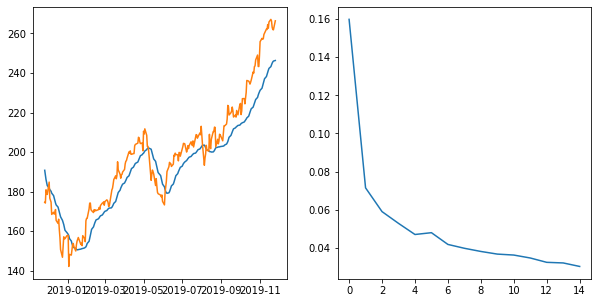

In [261]:
test_set_predicted = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predicted))
print('Test Score: %.2f RMSE' % (testScore_rnn))

test_set_predicted = sc.inverse_transform(test_set_predicted)
test_set_predicted = pd.DataFrame(test_set_predicted)# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_set_predicted.index = testing_set[look_back:].index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_set_predicted)
plt.plot(testing_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

In [262]:
#Partitioning dataset for training and testing 
univariate_seq = AAPL['Close']
training_set, testing_set =  univariate_data_setup(univariate_seq, 60, 0.8)


#Scaling the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))


X_train, Y_train, X_test, Y_test = univariate_partition_data(training_set_scaled, testing_set_scaled, 60)

#Reshaping X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#Creating a model
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l2(0.0001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.001), return_sequences= True))

regressor.add(LSTM(units = 25, 
                   kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.0001), bias_regularizer=l2(0.001), return_sequences = True))
regressor.add(Dropout(0.1))


regressor.add(LSTM(units=25))
regressor.add(Dropout(.25))

# Adding the output layer
regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam' , loss = 'mean_squared_error')
# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 15, batch_size = 50)



Train on 946 samples
Epoch 1/15
946/946 [==============================] - 5s 5ms/sample - loss: 0.1740
Epoch 2/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.1001
Epoch 3/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.0885
Epoch 4/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.0808
Epoch 5/15
946/946 [==============================] - 1s 2ms/sample - loss: 0.0746
Epoch 6/15
946/946 [==============================] - 1s 1ms/sample - loss: 0.0693
Epoch 7/15
946/946 [==============================] - 1s 1ms/sample - loss: 0.0655
Epoch 8/15
946/946 [==============================] - 1s 1ms/sample - loss: 0.0621
Epoch 9/15
946/946 [==============================] - 1s 1ms/sample - loss: 0.0590
Epoch 10/15
946/946 [==============================] - 1s 1ms/sample - loss: 0.0555
Epoch 11/15
946/946 [==============================] - 1s 1ms/sample - loss: 0.0534
Epoch 12/15
946/946 [==============================] - 1s 1ms/sa

In [263]:
# evaluate the model
train_mse = regressor.evaluate(X_train, Y_train, verbose=0)
test_mse = regressor.evaluate(X_test, Y_test , verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.042, Test: 0.046


Train Score: 0.0444 RMSE


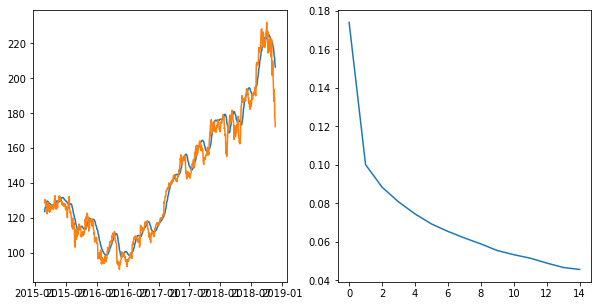

In [264]:
train_set_prediction = regressor.predict(X_train).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train,train_set_prediction))
print('Train Score: %.4f RMSE' % (trainScore_rnn))

train_set_prediction = sc.inverse_transform(train_set_prediction)
train_set_prediction = pd.DataFrame (train_set_prediction)

train_set_prediction.index = training_set[look_back:].index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_set_prediction)
plt.plot(training_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.08 RMSE


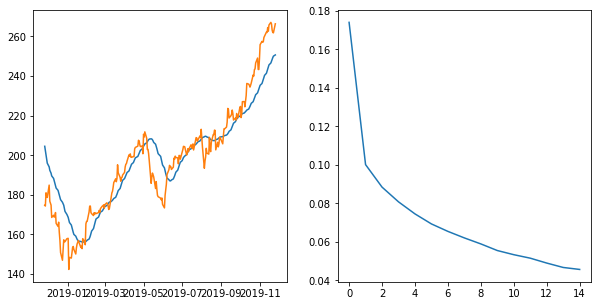

In [265]:
test_set_predicted = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predicted))
print('Test Score: %.2f RMSE' % (testScore_rnn))

test_set_predicted = sc.inverse_transform(test_set_predicted)
test_set_predicted = pd.DataFrame(test_set_predicted)# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_set_predicted.index = testing_set[look_back:].index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_set_predicted)
plt.plot(testing_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

## L1 and L2 with different optimizers(SGD, Adam, Adagrad)

In [266]:
#Partitioning dataset for training and testing 
univariate_seq = AAPL['Close']
training_set, testing_set =  univariate_data_setup(univariate_seq, 60, 0.8)


#Scaling the dataset
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.transform(testing_set.to_numpy().reshape(-1, 1))


X_train, Y_train, X_test, Y_test = univariate_partition_data(training_set_scaled, testing_set_scaled, 60)

#Reshaping X_train and X_test
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


#Creating a model
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 25, input_shape = (X_train.shape[1], 1), 
                   kernel_regularizer=l1_l2(l1 =0.001, l2 =0.001 ), recurrent_regularizer=l1_l2(l1= 0.001, l2 = .001), bias_regularizer=l1_l2(l1 = 0.01, l2 = 0.01)))
#regressor.add(Dropout(0.1))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 15, batch_size = 50)




Train on 946 samples
Epoch 1/15
946/946 [==============================] - 2s 2ms/sample - loss: 0.7971
Epoch 2/15
946/946 [==============================] - 0s 518us/sample - loss: 0.6854
Epoch 3/15
946/946 [==============================] - 0s 520us/sample - loss: 0.6324
Epoch 4/15
946/946 [==============================] - 1s 551us/sample - loss: 0.5878
Epoch 5/15
946/946 [==============================] - 0s 500us/sample - loss: 0.5498
Epoch 6/15
946/946 [==============================] - 1s 540us/sample - loss: 0.5171
Epoch 7/15
946/946 [==============================] - 0s 505us/sample - loss: 0.4886
Epoch 8/15
946/946 [==============================] - 0s 508us/sample - loss: 0.4634
Epoch 9/15
946/946 [==============================] - 0s 527us/sample - loss: 0.4412
Epoch 10/15
946/946 [==============================] - 0s 494us/sample - loss: 0.4214
Epoch 11/15
946/946 [==============================] - 0s 516us/sample - loss: 0.4037
Epoch 12/15
946/946 [=======================

In [267]:
# evaluate the model
train_mse = regressor.evaluate(X_train, Y_train, verbose=0)
test_mse = regressor.evaluate(X_test, Y_test , verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))

Train: 0.339, Test: 0.345


Train Score: 0.0350 RMSE


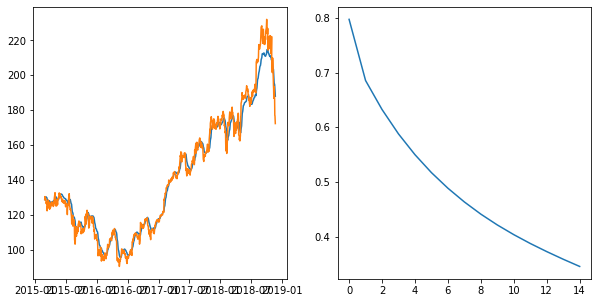

In [268]:
train_set_prediction = regressor.predict(X_train).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train,train_set_prediction))
print('Train Score: %.4f RMSE' % (trainScore_rnn))

train_set_prediction = sc.inverse_transform(train_set_prediction)
train_set_prediction = pd.DataFrame (train_set_prediction)

train_set_prediction.index = training_set[look_back:].index

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_set_prediction)
plt.plot(training_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.08 RMSE


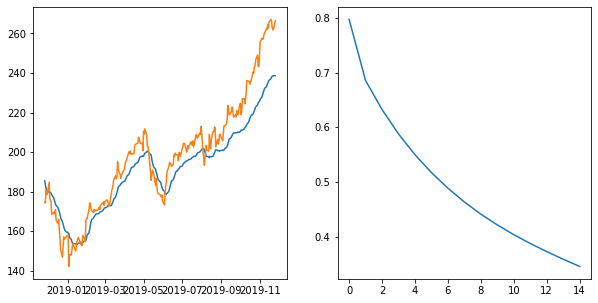

In [269]:
test_set_predicted = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predicted))
print('Test Score: %.2f RMSE' % (testScore_rnn))

test_set_predicted = sc.inverse_transform(test_set_predicted)
test_set_predicted = pd.DataFrame(test_set_predicted)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


test_set_predicted.index = testing_set[look_back:].index
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_set_predicted)
plt.plot(testing_set[look_back:])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

## Multi-Series Univariate Model

In [270]:
def multi_series_uni_setup(look_back_uni_series, train_percent, scUniSeries, scUniSeries2):
    close_columns = []
    for ind in data.columns:
        if(('Close' in ind) & ('Adj Close' not in ind) & (('AAPL' in ind) | ('MSFT' in ind))):
                close_columns.append(ind)
    dataset = scUniSeries.fit_transform(data[close_columns])
    dataset_sols = scUniSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))
    n_train = int(train_percent * len(dataset))
    training_set = dataset[:n_train]
    Y_train = dataset_sols[look_back_uni_series:n_train]
    testing_set = dataset[n_train - look_back_uni_series:]
    Y_test = dataset_sols[n_train:]
    return training_set, testing_set, Y_train, Y_test
    
def multi_series_uni_data_partition(look_back_uni_series, training_set, testing_set):
    X_train =[]
    Y_train = []
    X_test = []
    Y_test = []
    for i in range(look_back_uni_series, training_set.shape[0]):
        X_train.append(training_set[i-look_back_uni_series:i, :])
    X_train = np.array(X_train)
    
    for i in range(look_back_uni_series, testing_set.shape[0]):
        X_test.append(testing_set[i-look_back_uni_series:i, :])
    X_test = np.array(X_test)
    
    return X_train, X_test
    
    
    

In [271]:
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))

training_set, testing_set, Y_train, Y_test = multi_series_uni_setup(60, 0.8, scUniSeries, scUniSeries2)

X_train , X_test = multi_series_uni_data_partition(60, training_set, testing_set)

In [272]:
# Initialising the RNN
regressor = Sequential()

regressor.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 60, 2)))
regressor.add(TimeDistributed(MaxPooling1D(pool_size=2)))
regressor.add(TimeDistributed(Flatten()))
regressor.add(LSTM(10, return_sequences = True, activation='relu'))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs = 10)

Train on 946 samples
Epoch 1/10
946/946 [==============================] - 1s 1ms/sample - loss: 0.0384
Epoch 2/10
946/946 [==============================] - 0s 118us/sample - loss: 0.0045
Epoch 3/10
946/946 [==============================] - 0s 124us/sample - loss: 0.0032
Epoch 4/10
946/946 [==============================] - 0s 126us/sample - loss: 0.0028
Epoch 5/10
946/946 [==============================] - 0s 137us/sample - loss: 0.0025
Epoch 6/10
946/946 [==============================] - 0s 122us/sample - loss: 0.0020
Epoch 7/10
946/946 [==============================] - 0s 120us/sample - loss: 0.0015
Epoch 8/10
946/946 [==============================] - 0s 123us/sample - loss: 0.0013
Epoch 9/10
946/946 [==============================] - 0s 126us/sample - loss: 0.0011
Epoch 10/10
946/946 [==============================] - 0s 127us/sample - loss: 9.7939e-04


Train Score: 0.03 RMSE


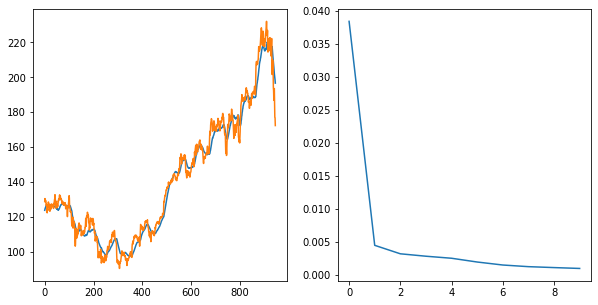

In [273]:
train_set_predict = regressor.predict(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train, train_set_predict))
print('Train Score: %.2f RMSE' % (trainScore_rnn))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(train_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.09 RMSE


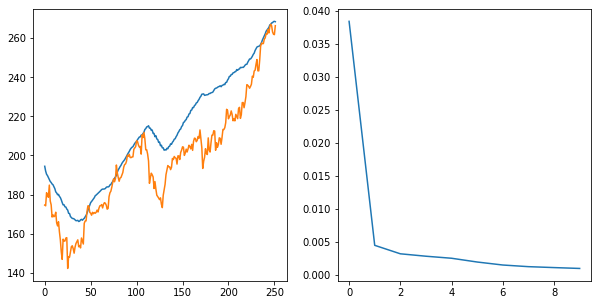

In [274]:
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)

test_set_predict = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predict))
print('Test Score: %.2f RMSE' % (testScore_rnn))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(test_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_test))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

In [275]:
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))

training_set, testing_set, Y_train, Y_test = multi_series_uni_setup(60, 0.8, scUniSeries, scUniSeries2)

X_train , X_test = multi_series_uni_data_partition(60, training_set, testing_set)

In [276]:
# Initialising the RNN
regressor = Sequential()

regressor.add(TimeDistributed(Conv1D(filters = 64, kernel_size=1), input_shape=(None, 60, 2)))
regressor.add(TimeDistributed(MaxPooling1D(pool_size=2)))
regressor.add(TimeDistributed(Flatten()))

regressor.add(LSTM(10, return_sequences = True, activation='relu'))

regressor.add(LSTM(10, return_sequences = True, activation='relu'))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs = 10)


Train on 946 samples
Epoch 1/10
946/946 [==============================] - 2s 2ms/sample - loss: 0.0746
Epoch 2/10
946/946 [==============================] - 0s 145us/sample - loss: 0.0049
Epoch 3/10
946/946 [==============================] - 0s 148us/sample - loss: 0.0026
Epoch 4/10
946/946 [==============================] - 0s 158us/sample - loss: 0.0024
Epoch 5/10
946/946 [==============================] - 0s 161us/sample - loss: 0.0023
Epoch 6/10
946/946 [==============================] - 0s 150us/sample - loss: 0.0022
Epoch 7/10
946/946 [==============================] - 0s 157us/sample - loss: 0.0020
Epoch 8/10
946/946 [==============================] - 0s 159us/sample - loss: 0.0019
Epoch 9/10
946/946 [==============================] - 0s 162us/sample - loss: 0.0016
Epoch 10/10
946/946 [==============================] - 0s 147us/sample - loss: 0.0014


Train Score: 0.03 RMSE


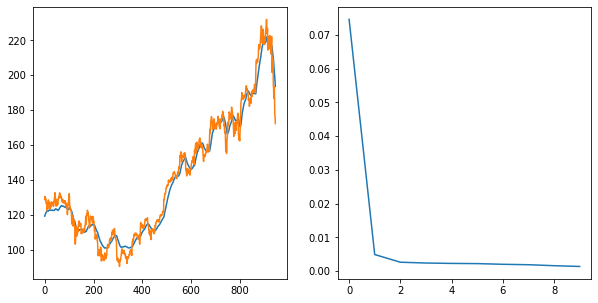

In [277]:
train_set_predict = regressor.predict(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train, train_set_predict))
print('Train Score: %.2f RMSE' % (trainScore_rnn))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(train_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.05 RMSE


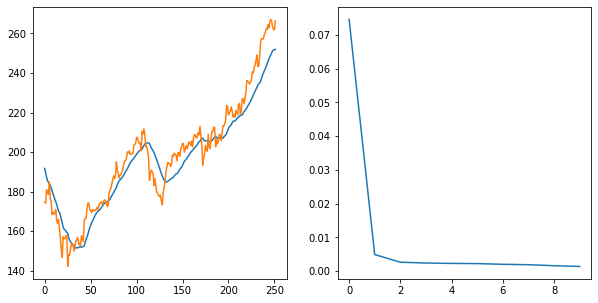

In [278]:
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)

test_set_predict = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predict))
print('Test Score: %.2f RMSE' % (testScore_rnn))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(test_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_test))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

In [284]:
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))

training_set, testing_set, Y_train, Y_test = multi_series_uni_setup(60, 0.8, scUniSeries, scUniSeries2)

X_train , X_test = multi_series_uni_data_partition(60, training_set, testing_set)

In [285]:
# Initialising the RNN
regressor = Sequential()

regressor.add(TimeDistributed(Conv1D(filters = 32, kernel_size=1), input_shape=(None, 60, 2)))
regressor.add(TimeDistributed(MaxPooling1D(pool_size=2)))
regressor.add(TimeDistributed(Flatten()))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs = 10)


Train on 946 samples
Epoch 1/10
946/946 [==============================] - 0s 468us/sample - loss: 0.0427
Epoch 2/10
946/946 [==============================] - 0s 87us/sample - loss: 0.0030
Epoch 3/10
946/946 [==============================] - 0s 97us/sample - loss: 0.0021
Epoch 4/10
946/946 [==============================] - 0s 93us/sample - loss: 0.0018
Epoch 5/10
946/946 [==============================] - 0s 78us/sample - loss: 0.0015
Epoch 6/10
946/946 [==============================] - 0s 84us/sample - loss: 0.0014
Epoch 7/10
946/946 [==============================] - 0s 90us/sample - loss: 0.0012
Epoch 8/10
946/946 [==============================] - 0s 91us/sample - loss: 0.0011
Epoch 9/10
946/946 [==============================] - 0s 86us/sample - loss: 9.7414e-04
Epoch 10/10
946/946 [==============================] - 0s 87us/sample - loss: 8.9888e-04


Train Score: 0.03 RMSE


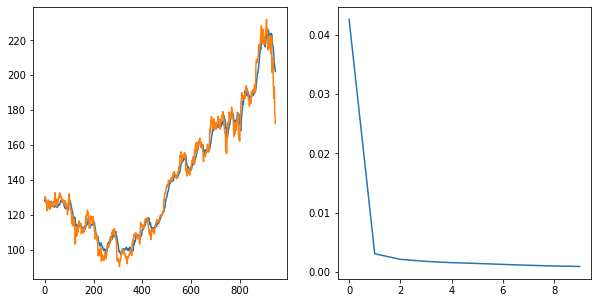

In [286]:
train_set_predict = regressor.predict(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train, train_set_predict))
print('Train Score: %.2f RMSE' % (trainScore_rnn))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(train_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.05 RMSE


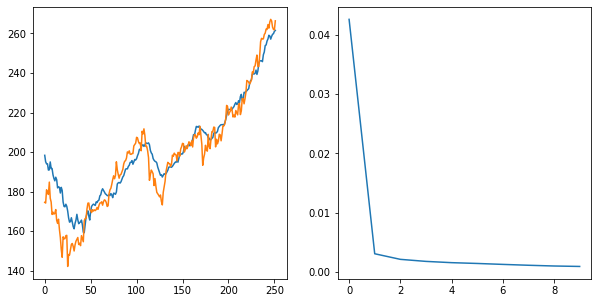

In [287]:
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)

test_set_predict = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predict))
print('Test Score: %.2f RMSE' % (testScore_rnn))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(test_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_test))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

In [291]:
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))

training_set, testing_set, Y_train, Y_test = multi_series_uni_setup(60, 0.8, scUniSeries, scUniSeries2)

X_train , X_test = multi_series_uni_data_partition(60, training_set, testing_set)

In [292]:
# Initialising the RNN
regressor = Sequential()

regressor.add(TimeDistributed(Conv1D(filters = 32, kernel_size=1), input_shape=(None, 60, 2)))
regressor.add(TimeDistributed(MaxPooling1D(pool_size=2)))
regressor.add(TimeDistributed(Flatten()))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adagrad', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2]), Y_train, epochs = 10)

Train on 946 samples
Epoch 1/10
946/946 [==============================] - 0s 492us/sample - loss: 0.0399
Epoch 2/10
946/946 [==============================] - 0s 84us/sample - loss: 0.0041
Epoch 3/10
946/946 [==============================] - 0s 92us/sample - loss: 0.0038
Epoch 4/10
946/946 [==============================] - 0s 101us/sample - loss: 0.0036
Epoch 5/10
946/946 [==============================] - 0s 104us/sample - loss: 0.0034
Epoch 6/10
946/946 [==============================] - 0s 91us/sample - loss: 0.0033
Epoch 7/10
946/946 [==============================] - 0s 82us/sample - loss: 0.0032
Epoch 8/10
946/946 [==============================] - 0s 99us/sample - loss: 0.0030
Epoch 9/10
946/946 [==============================] - 0s 101us/sample - loss: 0.0030
Epoch 10/10
946/946 [==============================] - 0s 94us/sample - loss: 0.0029


Train Score: 0.05 RMSE


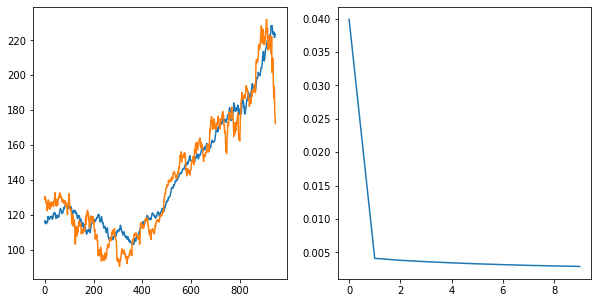

In [293]:
train_set_predict = regressor.predict(X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train, train_set_predict))
print('Train Score: %.2f RMSE' % (trainScore_rnn))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(train_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

Test Score: 0.13 RMSE


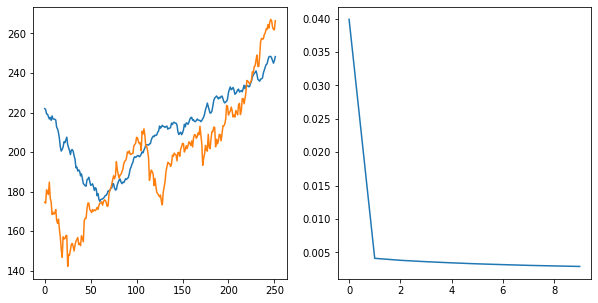

In [294]:
# Use the following line for convNN
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)

test_set_predict = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, test_set_predict))
print('Test Score: %.2f RMSE' % (testScore_rnn))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(test_set_predict))
plt.plot(scUniSeries2.inverse_transform(Y_test))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])

 This model above was already overfitting because we do not have a lot of inputs so I reduced the complexity of the model to reduce overfitting.

## Univariate Model With GRU

In [304]:
look_back_uni_series = 60
close_columns = []
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))
for ind in data.columns:
    if(('Close' in ind) & ('Adj Close' not in ind) & ('AAPL' in ind)):
        close_columns.append(ind)
univariate_seqs = scUniSeries.fit_transform(data[close_columns])
univariate_sols = scUniSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))
train_percent = .8
n_train = int(train_percent * len(univariate_seqs))
training_set = univariate_seqs[:n_train]
Y_train = univariate_sols[look_back_uni_series:n_train]
testing_set = univariate_seqs[n_train - look_back_uni_series:]
Y_test = univariate_sols[n_train:]


X_train = []
y_train = []
for i in range(look_back_uni_series, training_set.shape[0]):
    X_train.append(training_set[i-look_back_uni_series:i, :])
X_train = np.array(X_train)

Train on 946 samples
Epoch 1/10
946/946 [==============================] - 4s 4ms/sample - loss: 0.0290
Epoch 2/10
946/946 [==============================] - 2s 2ms/sample - loss: 0.0018
Epoch 3/10
946/946 [==============================] - 2s 2ms/sample - loss: 6.3960e-04
Epoch 4/10
946/946 [==============================] - 2s 2ms/sample - loss: 5.9218e-04
Epoch 5/10
946/946 [==============================] - 2s 2ms/sample - loss: 5.4457e-04
Epoch 6/10
946/946 [==============================] - 2s 2ms/sample - loss: 5.1481e-04
Epoch 7/10
946/946 [==============================] - 2s 2ms/sample - loss: 5.0403e-04
Epoch 8/10
946/946 [==============================] - 2s 2ms/sample - loss: 4.7648e-04
Epoch 9/10
946/946 [==============================] - 2s 2ms/sample - loss: 4.5182e-04
Epoch 10/10
946/946 [==============================] - 2s 2ms/sample - loss: 4.2288e-04
Train Score: 0.02 RMSE


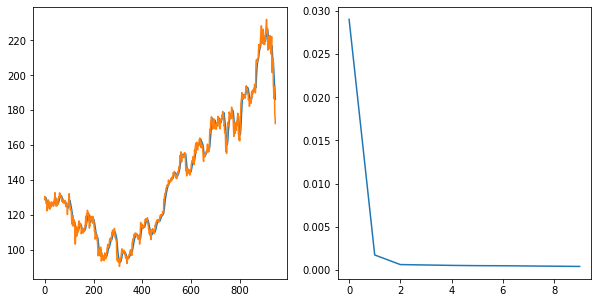

In [305]:


# Initialising the RNN
regressor = Sequential()
regressor.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(LSTM(10))
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 10)
predicted_stock_price = regressor.predict(X_train).reshape(-1, 1)

trainScore_rnn = math.sqrt(mean_squared_error(Y_train, predicted_stock_price))
print('Train Score: %.2f RMSE' % (trainScore_rnn))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])


Test Score: 0.03 RMSE


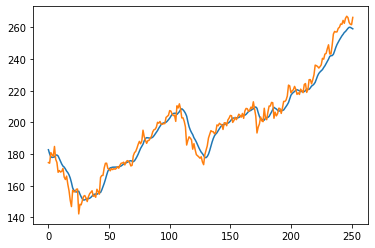

In [306]:
X_test = []
for i in range(look_back_uni_series, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back_uni_series:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, predicted_stock_price))
print('Test Score: %.2f RMSE' % (testScore_rnn))

#plotting test data
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_test))
plt.show()

### GRU experimenting

In [307]:
look_back_uni_series = 60
close_columns = []
scUniSeries = MinMaxScaler(feature_range = (0, 1))
scUniSeries2 = MinMaxScaler(feature_range = (0, 1))
for ind in data.columns:
    if(('Close' in ind) & ('Adj Close' not in ind) & ('AAPL' in ind)):
        close_columns.append(ind)
univariate_seqs = scUniSeries.fit_transform(data[close_columns])
univariate_sols = scUniSeries2.fit_transform(data["Close AAPL"].to_numpy().reshape(-1, 1))
train_percent = .8
n_train = int(train_percent * len(univariate_seqs))
training_set = univariate_seqs[:n_train]
Y_train = univariate_sols[look_back_uni_series:n_train]
testing_set = univariate_seqs[n_train - look_back_uni_series:]
Y_test = univariate_sols[n_train:]


X_train = []
y_train = []
for i in range(look_back_uni_series, training_set.shape[0]):
    X_train.append(training_set[i-look_back_uni_series:i, :])
X_train = np.array(X_train)

Train on 946 samples
Epoch 1/20
946/946 [==============================] - 8s 8ms/sample - loss: 0.0206
Epoch 2/20
946/946 [==============================] - 6s 6ms/sample - loss: 0.0013
Epoch 3/20
946/946 [==============================] - 6s 6ms/sample - loss: 0.0010
Epoch 4/20
946/946 [==============================] - 6s 6ms/sample - loss: 7.7241e-04
Epoch 5/20
946/946 [==============================] - 6s 6ms/sample - loss: 7.1269e-04
Epoch 6/20
946/946 [==============================] - 6s 6ms/sample - loss: 6.3810e-04
Epoch 7/20
946/946 [==============================] - 6s 6ms/sample - loss: 6.4224e-04
Epoch 8/20
946/946 [==============================] - 6s 6ms/sample - loss: 6.2724e-04
Epoch 9/20
946/946 [==============================] - 6s 6ms/sample - loss: 5.9063e-04
Epoch 10/20
946/946 [==============================] - 6s 6ms/sample - loss: 5.1756e-04
Epoch 11/20
946/946 [==============================] - 6s 6ms/sample - loss: 6.0756e-04
Epoch 12/20
946/946 [===========

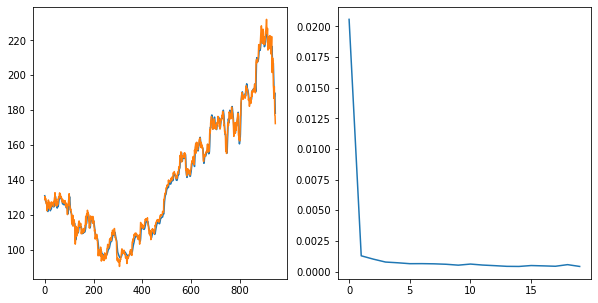

In [308]:
regressor = Sequential()
regressor.add(GRU(units=512,
              return_sequences=True,
              input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
regressor.add(GRU(units=256))
regressor.add(Dropout(0.2))
regressor.add(Dense(1, activation='sigmoid'))
regressor.compile(loss='mse', optimizer='adam')

# Fitting the RNN to the Training set
history = regressor.fit(X_train, Y_train, epochs = 20)
predicted_stock_price = regressor.predict(X_train).reshape(-1, 1)
trainScore_rnn = math.sqrt(mean_squared_error(Y_train, predicted_stock_price))
print('Train Score: %.2f RMSE' % (trainScore_rnn))


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_train))

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])


Test Score: 0.04 RMSE


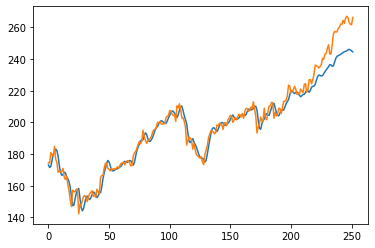

In [309]:
X_test = []
for i in range(look_back_uni_series, testing_set.shape[0]):
    X_test.append(testing_set[i-look_back_uni_series:i, :])

X_test = np.array(X_test)
# Use the following line for convNN
X_test = X_test
# predicted_stock_price = regressor.predict(X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])).reshape(-1, 1)
predicted_stock_price = regressor.predict(X_test).reshape(-1, 1)

testScore_rnn = math.sqrt(mean_squared_error(Y_test, predicted_stock_price))
print('Test Score: %.2f RMSE' % (testScore_rnn))


#plotting test data
plt.plot(scUniSeries2.inverse_transform(predicted_stock_price))
plt.plot(scUniSeries2.inverse_transform(Y_test))
plt.show()